# Wheel Test 2018-09-25
Testing new magic wheels on Jif.

In [1]:
%matplotlib inline
import pandas as pd

In [2]:
date = '2018-09-25'
activity_meta = pd.read_pickle("data/meta-%s.pkl.gz" % date)
activity_data = pd.read_pickle("data/data-%s.pkl.gz" % date)

## TPI Grouped by Direction
Select and pivot summary data for an activity.

In [3]:
pivot = activity_data.pivot(index='id', columns='measure', values='value')
activity = pd.merge(activity_meta, pivot, on='id')
activity['tpi'] = activity['actual_ticks'] / activity['actual_distance']
activity[['direction','actual_distance', 'tpi']].groupby('direction').describe().round(1)

actual_distance                                                 \
                    count   mean  std    min    25%    50%    75%    max   
direction                                                                  
-90.0                10.0  131.5  0.5  130.8  131.3  131.4  131.9  132.2   
0.0                  10.0  131.4  0.6  130.5  131.0  131.5  131.9  132.2   
180.0                10.0  133.4  0.5  132.4  133.0  133.4  133.8  134.0   
90.0                 10.0  131.6  0.6  130.8  131.2  131.7  132.1  132.5   

            tpi                                                       
          count    mean  std     min     25%     50%     75%     max  
direction                                                             
-90.0      10.0  1904.5  8.0  1889.7  1899.3  1904.8  1909.3  1918.4  
0.0        10.0  1908.5  8.6  1893.4  1902.1  1909.9  1914.4  1920.0  
180.0      10.0  1876.2  8.9  1863.2  1870.5  1876.4  1880.6  1893.2  
90.0       10.0  1901.4  9.5  1886.5  1894.3  1901.8  1909.2  1913.0

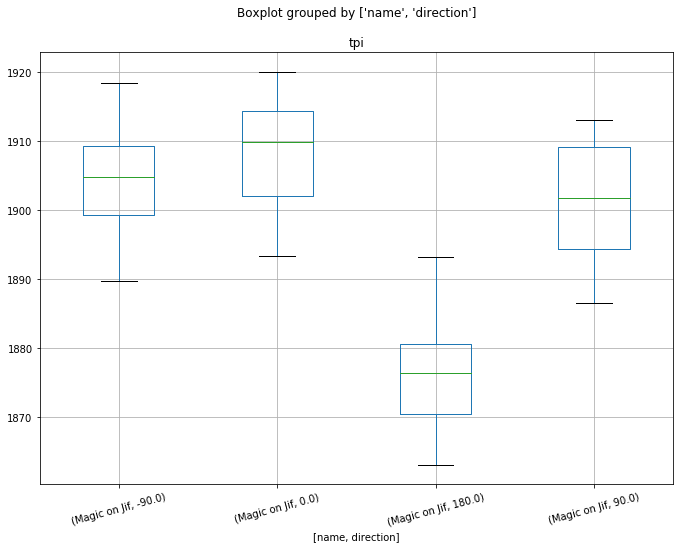

In [4]:
activity.boxplot(column='tpi', by=['name', 'direction'], rot=15, figsize=(11, 8))

## TPI Estimated Error by Direction
A resonable choice for nominal TPI is either *forward* TPI or TPI *grand mean*. We'll assume the TPI nominal value is the grand mean of all TPI measurements.

\begin{equation*}
error_{TPI} =  \frac{TPI_{experimental} - TPI_{nominal}}{TPI_{nominal}} \times 100\%
\end{equation*}

A positive error is more ticks per inch (conversely fewer inches per tick), therefore the robot travels less distance with postive error. The `100 in.` column below is how far we'd expect the robot to travel if we converted 100 in to ticks using the forward (0.0) TPI as our benchmark.

In [5]:
tpi_grand_mean = activity['tpi'].mean()
tpi_error = activity[['direction', 'tpi']].groupby('direction').mean()
tpi_error['error'] = (tpi_error['tpi'] - tpi_grand_mean) / tpi_grand_mean
tpi_error['error (%)'] = pd.Series(["{0:.2f}%".format(val * 100) for val in tpi_error['error']], index = tpi_error.index)

ticks_100_in = tpi_error.loc['0.0','tpi'] * 100 # ticks to travel 100in using 0.0 TPI
tpi_error['100 in.'] = ticks_100_in / tpi_error['tpi']
tpi_error = tpi_error.round({'tpi':1, 'error': 3, '100 in.': 2})
tpi_error

,tpi,error,error (%),100 in.
direction,,,,
-90.0,1904.5,0.004,0.36%,100.21
0.0,1908.5,0.006,0.57%,100.00
180.0,1876.2,-0.011,-1.13%,101.72
90.0,1901.4,0.002,0.20%,100.37


## Notes

The data for `activity_meta` can be reconstructed from the datebase with this query:
    
```sql
SELECT id, name, timestamp, meta->'direction' AS direction
FROM tc_activity
WHERE timestamp::date = date '2018-09-25' AND data[3] <> 0
```

The data for `activity_data` can be reconstructed from the datebase with this query:

```sql
SELECT id, name, timestamp, measure, value
FROM tc_activity, unnest(activity_measures, data) AS u(measure, value)
WHERE timestamp::date = date '2018-09-25' AND data[3] <> 0
```